In [1]:
!pip install tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 85.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 86.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 50.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempti

In [2]:
!pip show tensorflow

Name: tensorflow
Version: 2.9.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: explainable-ai-sdk, tensorflow-cloud, tensorflow-decision-forests, tensorflow-serving-api, tensorflow-text, tensorflowjs, witwidget


In [3]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


modules loaded


In [19]:
# Generate data paths with labels
train_data_dir = '/kaggle/input/skin-cancer-malignant-vs-benign/train'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
train_df

,filepaths,labels
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
...,...,...
2632,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2633,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2634,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2635,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant


In [6]:
# Generate data paths with labels
test_data_dir = '/kaggle/input/skin-cancer-malignant-vs-benign/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [7]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2637 validated image filenames belonging to 2 classes.
Found 660 validated image filenames belonging to 2 classes.


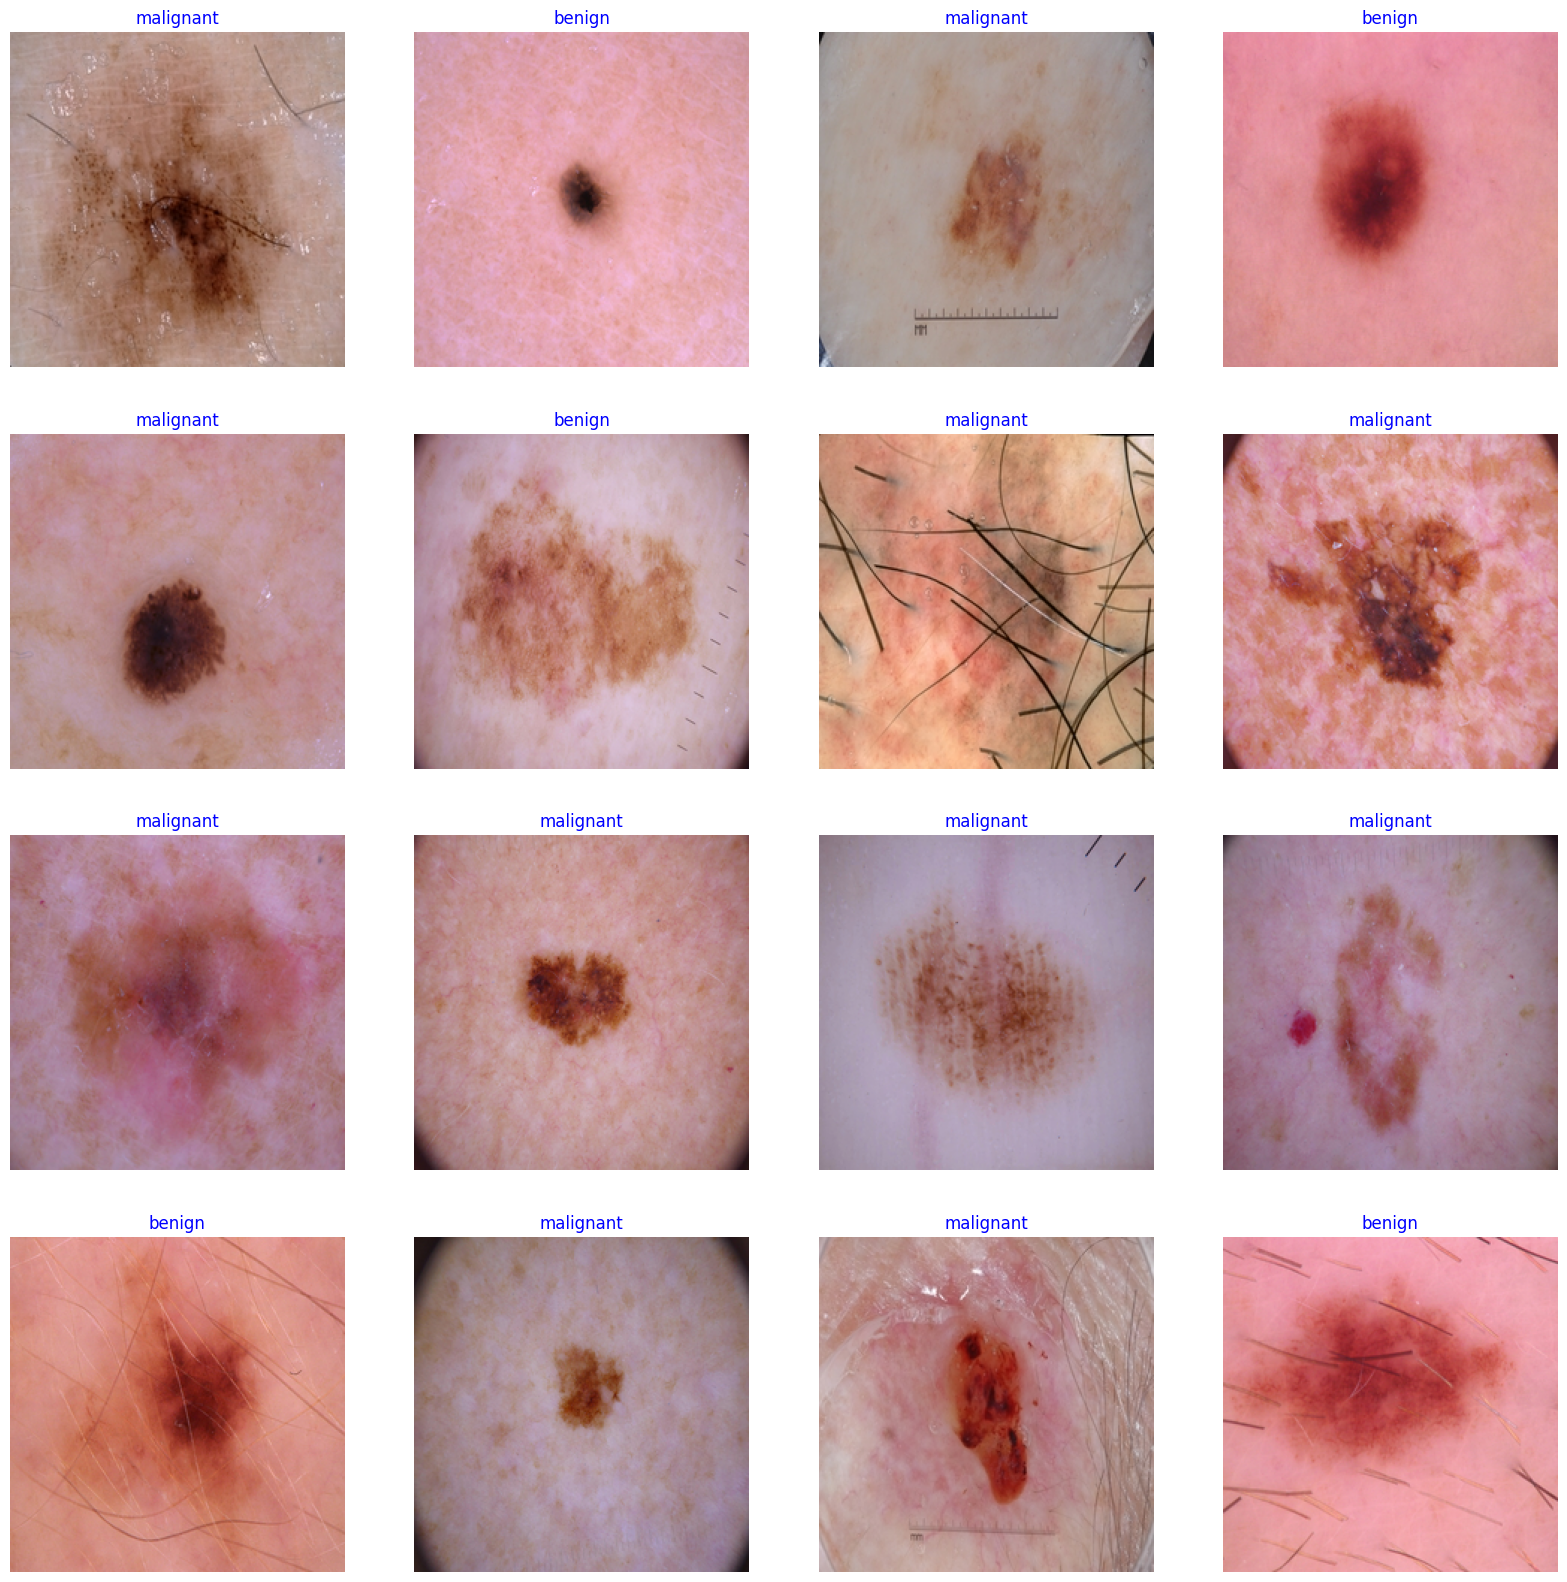

In [5]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [8]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11,183,665
Trainable params: 11,093,290
Non

In [9]:
epochs = 25   # number of all epochs in training

model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/25
165/165 [==============================] - 63s 278ms/step - loss: 6.0882 - accuracy: 0.7854 - val_loss: 4.7013 - val_accuracy: 0.8333
Epoch 2/25
165/165 [==============================] - 39s 234ms/step - loss: 3.6553 - accuracy: 0.8631 - val_loss: 3.0061 - val_accuracy: 0.8833
Epoch 3/25
165/165 [==============================] - 39s 235ms/step - loss: 2.5181 - accuracy: 0.8980 - val_loss: 2.1297 - val_accuracy: 0.8955
Epoch 4/25
165/165 [==============================] - 39s 234ms/step - loss: 1.7879 - accuracy: 0.9295 - val_loss: 1.6018 - val_accuracy: 0.8742
Epoch 5/25
165/165 [==============================] - 38s 232ms/step - loss: 1.2583 - accuracy: 0.9564 - val_loss: 1.1843 - val_accuracy: 0.8924
Epoch 6/25
165/165 [==============================] - 39s 234ms/step - loss: 0.9090 - accuracy: 0.9621 - val_loss: 0.9270 - val_accuracy: 0.8909
Epoch 7/25
165/165 [==============================] - 39s 234ms/step - loss: 0.6552 - accuracy: 0.9712 - val_loss: 0.8412 - val_ac

In [10]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

10/10 [==============================] - 1s 60ms/step - loss: 0.5069 - accuracy: 0.8562
Train Loss:  0.0737452283501625
Train Accuracy:  1.0
--------------------
Test Loss:  0.5069031715393066
Test Accuracy:  0.856249988079071


In [12]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

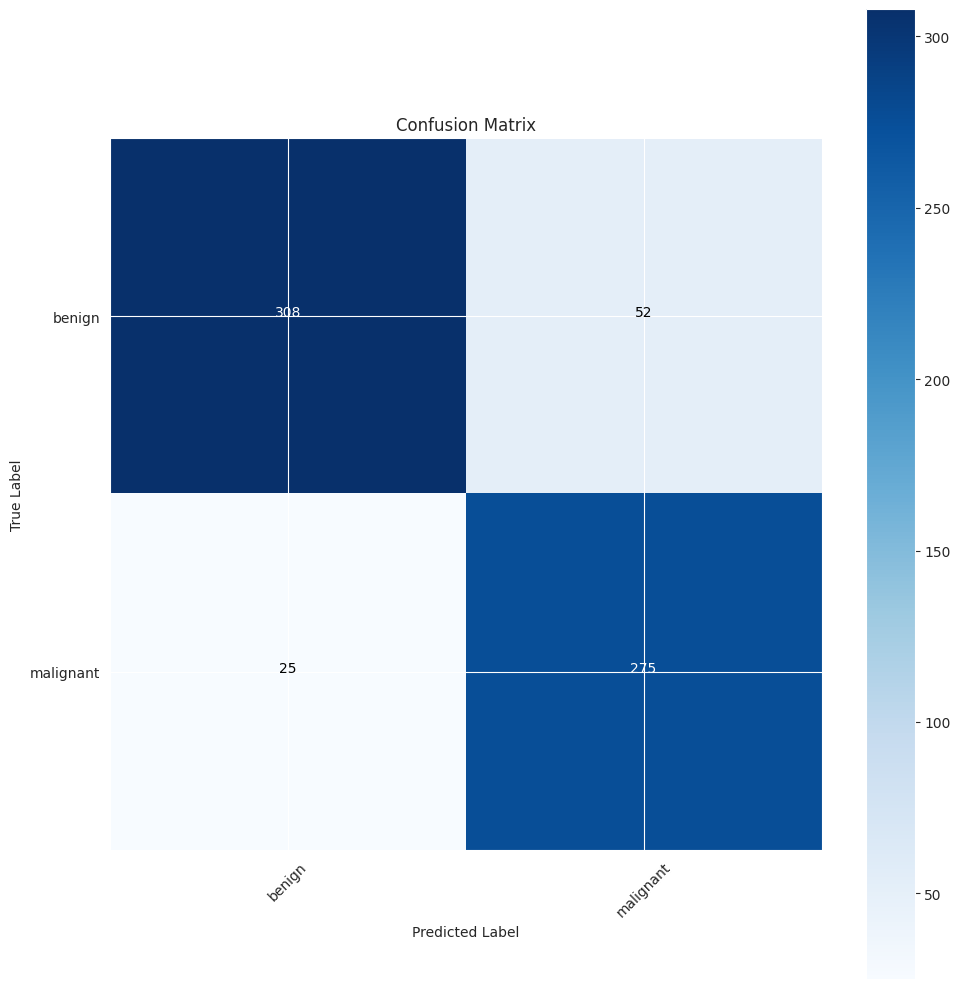

In [13]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [12]:
model.save('Skin_Cancer.h5')

In [21]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 29,046,777
Trainable params: 28,869,938
Non-trainable params: 176,839
____________________________________

In [22]:
epochs = 20   # number of all epochs in training

model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/20
165/165 [==============================] - 87s 401ms/step - loss: 6.8591 - accuracy: 0.7543 - val_loss: 5.6325 - val_accuracy: 0.7894
Epoch 2/20
165/165 [==============================] - 62s 376ms/step - loss: 4.3754 - accuracy: 0.8586 - val_loss: 3.7818 - val_accuracy: 0.8515
Epoch 3/20
165/165 [==============================] - 62s 377ms/step - loss: 2.9921 - accuracy: 0.9105 - val_loss: 2.6016 - val_accuracy: 0.8879
Epoch 4/20
165/165 [==============================] - 62s 377ms/step - loss: 2.1027 - accuracy: 0.9492 - val_loss: 1.9387 - val_accuracy: 0.8667
Epoch 5/20
165/165 [==============================] - 62s 377ms/step - loss: 1.5141 - accuracy: 0.9587 - val_loss: 1.3939 - val_accuracy: 0.8924
Epoch 6/20
165/165 [==============================] - 62s 377ms/step - loss: 1.0777 - accuracy: 0.9719 - val_loss: 1.0836 - val_accuracy: 0.8894
Epoch 7/20
165/165 [==============================] - 62s 377ms/step - loss: 0.7927 - accuracy: 0.9704 - val_loss: 0.8392 - val_ac

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [24]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

10/10 [==============================] - 1s 71ms/step - loss: 0.3706 - accuracy: 0.9125
Train Loss:  0.11474204063415527
Train Accuracy:  1.0
--------------------
Test Loss:  0.3705502152442932
Test Accuracy:  0.9125000238418579


In [25]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

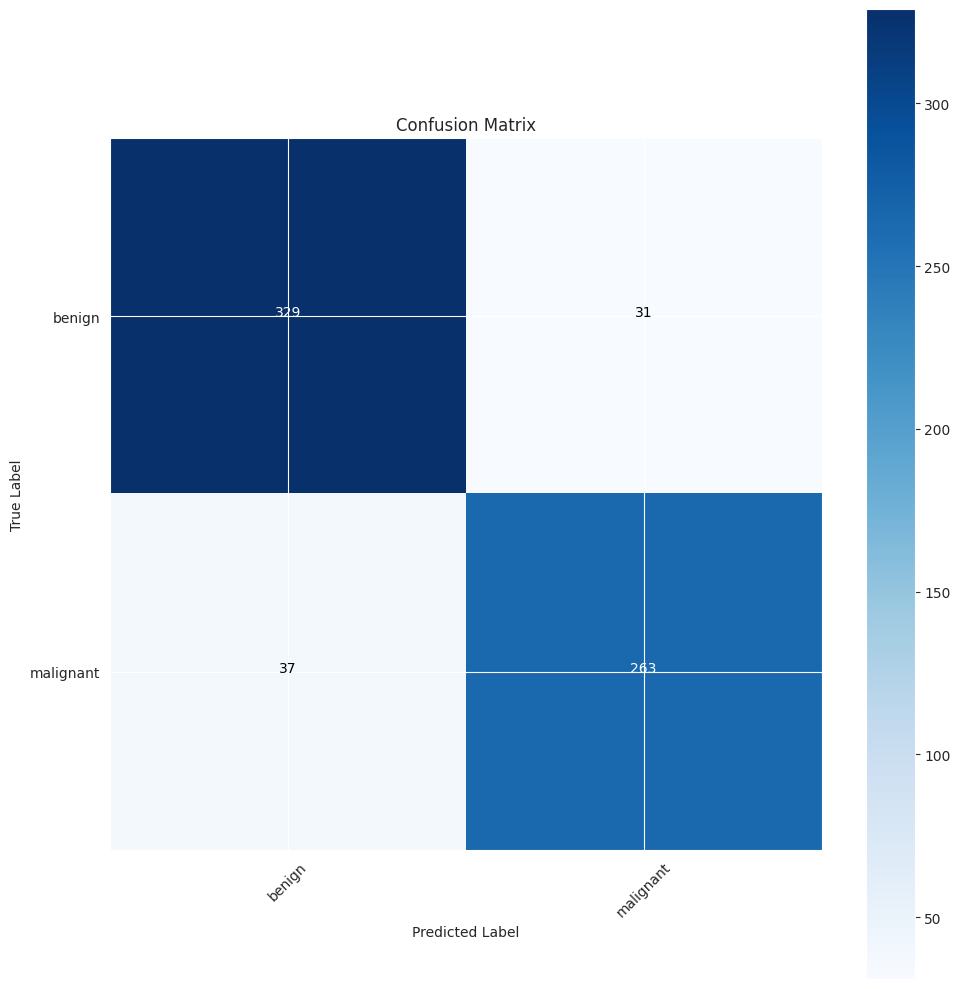

In [26]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score,mean_absolute_error
"""precision = precision_score(preds, y_pred)
recall = recall_score(preds, y_pred)
f1 = f1_score(preds, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)"""

print(mean_absolute_error(preds, y_pred))